# VAE Volatility Surface Experiments

This notebook provides a clean workflow for:
1. Loading processed volatility surface data
2. Training VAE models (grid-wise and pointwise)
3. Evaluating surface completion with masking (0%, 25%, 50%, 75%)
4. Visualizing reconstructions

In [ ]:
# Imports
import sys
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt

# Project imports
from src.data.dataloaders import create_dataloaders
from src.models import MLPVAE, ConvVAE, PointwiseMLPVAE, vae_loss, create_model
from src.utils import (
    fit_vae,
    evaluate_vae,
    evaluate_completion_sweep,
    print_completion_summary,
    create_random_mask,
)

## 1. Configuration

In [ ]:
# Paths (updated for new folder structure)
PARQUET_PATH = Path("../../data/processed/vae/parquet/AAPL_vsurf_processed.parquet")
CHECKPOINT_DIR = Path("../../artifacts/train")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# ── Toggle: architecture & log-transform ──────────────────────────────
MODEL_TYPE = "mlp"          # "mlp" or "conv"
USE_LOG_TRANSFORM = False   # True → train in log-IV space

# Model configuration (sweep-best defaults)
LATENT_DIM = 24

# MLP-specific (used when MODEL_TYPE == "mlp")
HIDDEN_DIMS = [384, 192]

# Conv-specific (used when MODEL_TYPE == "conv")
CHANNELS = [32, 64, 128]
FC_DIM = 128
BATCHNORM = True

# Training configuration (sweep-best defaults)
BATCH_SIZE = 64
EPOCHS = 1000
LR = 7e-4
BETA = 0.25               # KL weight
WEIGHT_DECAY = 1e-6        # L2 regularization
PATIENCE = 100             # Early stopping

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Model type: {MODEL_TYPE} | Log-transform: {USE_LOG_TRANSFORM}")

Using device: cuda


## 2. Load Data

In [ ]:
# Create dataloaders (chronological split, normalized)
bundle = create_dataloaders(
    parquet_path=PARQUET_PATH,
    value_col="impl_volatility",
    train_ratio=0.80,
    val_ratio=0.10,
    batch_size=BATCH_SIZE,
    normalize=True,
    use_log_transform=USE_LOG_TRANSFORM,
    return_date=True,  # Return (x, date) tuples
)

print(f"Train: {len(bundle.train_loader.dataset)} samples")
print(f"Val:   {len(bundle.val_loader.dataset)} samples")
print(f"Test:  {len(bundle.test_loader.dataset)} samples")

# Check a batch shape
batch = next(iter(bundle.train_loader))
x, date = batch
print(f"Batch shape: {x.shape}")

Train: 1943 samples
Val:   242 samples
Test:  244 samples
Batch shape: torch.Size([32, 2, 11, 17])


## 3. Define Model

In [ ]:
# Use actual shape from loaded data (not hardcoded)
GRID_SHAPE = bundle.input_shape
print(f"Grid shape from data: {GRID_SHAPE} = {np.prod(GRID_SHAPE)} values")

# Create model via factory (supports MLP and Conv)
model = create_model(
    model_type=MODEL_TYPE,
    in_shape=GRID_SHAPE,
    latent_dim=LATENT_DIM,
    hidden_dims=tuple(HIDDEN_DIMS),
    channels=tuple(CHANNELS),
    fc_dim=FC_DIM,
    batchnorm=BATCHNORM,
).to(DEVICE)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Grid shape from data: (2, 11, 17) = 374 values
MLPVAE(
  (encoder): Sequential(
    (0): Linear(in_features=374, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=374, bias=True)
  )
)

Total parameters: 261,254


## 4. Train Model

In [ ]:
# Train with early stopping
history = fit_vae(
    model=model,
    train_loader=bundle.train_loader,
    val_loader=bundle.val_loader,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    beta=BETA,
    device=DEVICE,
    patience=PATIENCE,
    checkpoint_dir=CHECKPOINT_DIR,  # Directory, not file path
)

Epoch 001 | train: 0.746329 (recon 0.671792, kl 0.074537) | val: 0.423664 (recon 0.363211, kl 0.060452) *


Epoch 002 | train: 0.450503 (recon 0.294781, kl 0.155721) | val: 0.335593 (recon 0.242749, kl 0.092843) *


Epoch 003 | train: 0.391378 (recon 0.243534, kl 0.147844) | val: 0.354178 (recon 0.226658, kl 0.127520)


Epoch 004 | train: 0.357210 (recon 0.209838, kl 0.147372) | val: 0.304056 (recon 0.196227, kl 0.107829) *


Epoch 005 | train: 0.344064 (recon 0.206437, kl 0.137627) | val: 0.298810 (recon 0.193713, kl 0.105097) *


Epoch 006 | train: 0.350127 (recon 0.207374, kl 0.142753) | val: 0.312780 (recon 0.189583, kl 0.123197)


Epoch 007 | train: 0.342628 (recon 0.203503, kl 0.139124) | val: 0.301504 (recon 0.196247, kl 0.105257)


Epoch 008 | train: 0.346603 (recon 0.202318, kl 0.144286) | val: 0.331740 (recon 0.247766, kl 0.083974)


Epoch 009 | train: 0.348233 (recon 0.204249, kl 0.143984) | val: 0.312024 (recon 0.190861, kl 0.121163)


Epoch 010 | train: 0.346360 (recon 0.201126, kl 0.145234) | val: 0.313645 (recon 0.205534, kl 0.108111)


Epoch 011 | train: 0.346451 (recon 0.204554, kl 0.141897) | val: 0.306496 (recon 0.203089, kl 0.103407)


Epoch 012 | train: 0.338238 (recon 0.195116, kl 0.143122) | val: 0.309389 (recon 0.207303, kl 0.102086)


Epoch 013 | train: 0.340227 (recon 0.196134, kl 0.144093) | val: 0.304513 (recon 0.189837, kl 0.114676)


Epoch 014 | train: 0.340966 (recon 0.194788, kl 0.146178) | val: 0.293611 (recon 0.204675, kl 0.088936) *


Epoch 015 | train: 0.337866 (recon 0.193857, kl 0.144008) | val: 0.301452 (recon 0.191575, kl 0.109877)


Epoch 016 | train: 0.341102 (recon 0.192577, kl 0.148525) | val: 0.307358 (recon 0.181462, kl 0.125895)


Epoch 017 | train: 0.339187 (recon 0.192538, kl 0.146649) | val: 0.293702 (recon 0.185051, kl 0.108651)


Epoch 018 | train: 0.338334 (recon 0.196076, kl 0.142258) | val: 0.307674 (recon 0.215131, kl 0.092543)


Epoch 019 | train: 0.334025 (recon 0.188552, kl 0.145473) | val: 0.303147 (recon 0.206362, kl 0.096785)


Epoch 020 | train: 0.338819 (recon 0.191124, kl 0.147694) | val: 0.308012 (recon 0.192416, kl 0.115596)


Epoch 021 | train: 0.335710 (recon 0.184925, kl 0.150785) | val: 0.302849 (recon 0.183324, kl 0.119525)


Epoch 022 | train: 0.339441 (recon 0.192913, kl 0.146528) | val: 0.310206 (recon 0.173548, kl 0.136658)


Epoch 023 | train: 0.331774 (recon 0.186472, kl 0.145301) | val: 0.310319 (recon 0.213399, kl 0.096920)


Epoch 024 | train: 0.335405 (recon 0.186827, kl 0.148578) | val: 0.317414 (recon 0.200361, kl 0.117052)


Epoch 025 | train: 0.343095 (recon 0.195317, kl 0.147778) | val: 0.303632 (recon 0.187368, kl 0.116263)


Epoch 026 | train: 0.337320 (recon 0.183259, kl 0.154061) | val: 0.291720 (recon 0.183844, kl 0.107876) *


Epoch 027 | train: 0.339878 (recon 0.187795, kl 0.152083) | val: 0.302312 (recon 0.197334, kl 0.104978)


Epoch 028 | train: 0.332778 (recon 0.185286, kl 0.147492) | val: 0.311101 (recon 0.190932, kl 0.120169)


Epoch 029 | train: 0.329885 (recon 0.183936, kl 0.145949) | val: 0.282929 (recon 0.178115, kl 0.104815) *


Epoch 030 | train: 0.333841 (recon 0.186161, kl 0.147680) | val: 0.304015 (recon 0.191641, kl 0.112373)


Epoch 031 | train: 0.334443 (recon 0.188835, kl 0.145607) | val: 0.307381 (recon 0.183492, kl 0.123889)


Epoch 032 | train: 0.337532 (recon 0.185967, kl 0.151565) | val: 0.321975 (recon 0.221548, kl 0.100427)


Epoch 033 | train: 0.333587 (recon 0.187522, kl 0.146065) | val: 0.294579 (recon 0.178001, kl 0.116579)


Epoch 034 | train: 0.333243 (recon 0.184585, kl 0.148658) | val: 0.290958 (recon 0.200549, kl 0.090409)


Epoch 035 | train: 0.338724 (recon 0.187316, kl 0.151407) | val: 0.314952 (recon 0.186003, kl 0.128949)


Epoch 036 | train: 0.330784 (recon 0.184955, kl 0.145829) | val: 0.312271 (recon 0.215981, kl 0.096289)


Epoch 037 | train: 0.332601 (recon 0.182875, kl 0.149727) | val: 0.317106 (recon 0.214270, kl 0.102835)


Epoch 038 | train: 0.329049 (recon 0.180487, kl 0.148562) | val: 0.297564 (recon 0.191210, kl 0.106354)


Epoch 039 | train: 0.332722 (recon 0.185565, kl 0.147157) | val: 0.293637 (recon 0.182079, kl 0.111558)


Epoch 040 | train: 0.327689 (recon 0.182891, kl 0.144798) | val: 0.296371 (recon 0.186937, kl 0.109434)


Epoch 041 | train: 0.328463 (recon 0.180642, kl 0.147820) | val: 0.311994 (recon 0.175125, kl 0.136869)


Epoch 042 | train: 0.342501 (recon 0.189094, kl 0.153407) | val: 0.294489 (recon 0.204539, kl 0.089950)


Epoch 043 | train: 0.334747 (recon 0.188879, kl 0.145867) | val: 0.306981 (recon 0.186940, kl 0.120041)


Epoch 044 | train: 0.328675 (recon 0.183673, kl 0.145002) | val: 0.290075 (recon 0.178895, kl 0.111180)


Epoch 045 | train: 0.325211 (recon 0.181366, kl 0.143845) | val: 0.290202 (recon 0.189271, kl 0.100931)


Epoch 046 | train: 0.329551 (recon 0.183130, kl 0.146421) | val: 0.296768 (recon 0.181124, kl 0.115644)


Epoch 047 | train: 0.336682 (recon 0.186346, kl 0.150335) | val: 0.301925 (recon 0.195130, kl 0.106795)


Epoch 048 | train: 0.332696 (recon 0.180848, kl 0.151848) | val: 0.294856 (recon 0.191706, kl 0.103150)


Epoch 049 | train: 0.334020 (recon 0.184821, kl 0.149199) | val: 0.291560 (recon 0.184095, kl 0.107465)


Epoch 050 | train: 0.330621 (recon 0.183450, kl 0.147172) | val: 0.309581 (recon 0.173962, kl 0.135619)


Epoch 051 | train: 0.328338 (recon 0.176423, kl 0.151916) | val: 0.294495 (recon 0.183466, kl 0.111030)


Epoch 052 | train: 0.333010 (recon 0.182067, kl 0.150943) | val: 0.314624 (recon 0.183494, kl 0.131130)


Epoch 053 | train: 0.327539 (recon 0.182687, kl 0.144852) | val: 0.291996 (recon 0.209150, kl 0.082846)


Epoch 054 | train: 0.327774 (recon 0.181228, kl 0.146545) | val: 0.307043 (recon 0.194604, kl 0.112439)


Epoch 055 | train: 0.328544 (recon 0.179709, kl 0.148835) | val: 0.295613 (recon 0.187205, kl 0.108408)


Epoch 056 | train: 0.332786 (recon 0.184757, kl 0.148029) | val: 0.295641 (recon 0.188002, kl 0.107639)


Epoch 057 | train: 0.328803 (recon 0.178805, kl 0.149998) | val: 0.300692 (recon 0.195859, kl 0.104833)


Epoch 058 | train: 0.332045 (recon 0.182515, kl 0.149530) | val: 0.308825 (recon 0.210566, kl 0.098259)


Epoch 059 | train: 0.337553 (recon 0.186599, kl 0.150954) | val: 0.304290 (recon 0.183873, kl 0.120417)


Epoch 060 | train: 0.327686 (recon 0.184022, kl 0.143664) | val: 0.299360 (recon 0.185789, kl 0.113570)


Epoch 061 | train: 0.325410 (recon 0.178360, kl 0.147049) | val: 0.296911 (recon 0.195884, kl 0.101028)


Epoch 062 | train: 0.325125 (recon 0.178398, kl 0.146726) | val: 0.307357 (recon 0.174819, kl 0.132538)


Epoch 063 | train: 0.327765 (recon 0.180822, kl 0.146943) | val: 0.291816 (recon 0.185876, kl 0.105940)


Epoch 064 | train: 0.324535 (recon 0.178888, kl 0.145648) | val: 0.297983 (recon 0.186627, kl 0.111356)


Epoch 065 | train: 0.325616 (recon 0.181098, kl 0.144518) | val: 0.304730 (recon 0.211648, kl 0.093082)


Epoch 066 | train: 0.328177 (recon 0.178673, kl 0.149503) | val: 0.290739 (recon 0.197411, kl 0.093328)


Epoch 067 | train: 0.323119 (recon 0.178627, kl 0.144492) | val: 0.289868 (recon 0.180907, kl 0.108961)


Epoch 068 | train: 0.329487 (recon 0.183400, kl 0.146087) | val: 0.303033 (recon 0.198297, kl 0.104736)


Epoch 069 | train: 0.324582 (recon 0.180202, kl 0.144380) | val: 0.307088 (recon 0.183331, kl 0.123757)


Epoch 070 | train: 0.330858 (recon 0.179397, kl 0.151461) | val: 0.295475 (recon 0.190487, kl 0.104987)


Epoch 071 | train: 0.326733 (recon 0.179387, kl 0.147347) | val: 0.309191 (recon 0.197347, kl 0.111844)


Epoch 072 | train: 0.331141 (recon 0.180358, kl 0.150783) | val: 0.300109 (recon 0.186494, kl 0.113614)


Epoch 073 | train: 0.328410 (recon 0.180602, kl 0.147808) | val: 0.301376 (recon 0.203318, kl 0.098058)


Epoch 074 | train: 0.327859 (recon 0.181471, kl 0.146389) | val: 0.298186 (recon 0.185406, kl 0.112781)


Epoch 075 | train: 0.323940 (recon 0.177500, kl 0.146440) | val: 0.303888 (recon 0.181199, kl 0.122688)


Epoch 076 | train: 0.325499 (recon 0.177732, kl 0.147767) | val: 0.302905 (recon 0.188618, kl 0.114287)


Epoch 077 | train: 0.329599 (recon 0.181315, kl 0.148283) | val: 0.299581 (recon 0.178279, kl 0.121302)


Epoch 078 | train: 0.324062 (recon 0.174278, kl 0.149784) | val: 0.282998 (recon 0.185593, kl 0.097405)


Epoch 079 | train: 0.329902 (recon 0.181818, kl 0.148083) | val: 0.312397 (recon 0.193425, kl 0.118972)


Epoch 080 | train: 0.328125 (recon 0.181903, kl 0.146222) | val: 0.290508 (recon 0.199494, kl 0.091014)


Epoch 081 | train: 0.330658 (recon 0.181452, kl 0.149206) | val: 0.301906 (recon 0.198546, kl 0.103360)


Epoch 082 | train: 0.330514 (recon 0.179430, kl 0.151084) | val: 0.304344 (recon 0.207475, kl 0.096868)


Epoch 083 | train: 0.326429 (recon 0.178464, kl 0.147965) | val: 0.294876 (recon 0.198993, kl 0.095883)


Epoch 084 | train: 0.324135 (recon 0.176838, kl 0.147297) | val: 0.312567 (recon 0.218515, kl 0.094051)


Epoch 085 | train: 0.329372 (recon 0.177689, kl 0.151683) | val: 0.293649 (recon 0.169002, kl 0.124647)


Epoch 086 | train: 0.335326 (recon 0.181167, kl 0.154159) | val: 0.302081 (recon 0.175630, kl 0.126452)


Epoch 087 | train: 0.327396 (recon 0.177121, kl 0.150276) | val: 0.299298 (recon 0.180244, kl 0.119053)


Epoch 088 | train: 0.337865 (recon 0.183286, kl 0.154580) | val: 0.290943 (recon 0.188064, kl 0.102880)


Epoch 089 | train: 0.327846 (recon 0.180514, kl 0.147333) | val: 0.295308 (recon 0.193292, kl 0.102015)


Epoch 090 | train: 0.325017 (recon 0.179025, kl 0.145992) | val: 0.287121 (recon 0.189401, kl 0.097719)


Epoch 091 | train: 0.328412 (recon 0.180102, kl 0.148310) | val: 0.294001 (recon 0.192670, kl 0.101331)


Epoch 092 | train: 0.331373 (recon 0.183607, kl 0.147766) | val: 0.309297 (recon 0.195419, kl 0.113878)


Epoch 093 | train: 0.328511 (recon 0.177693, kl 0.150817) | val: 0.316936 (recon 0.200336, kl 0.116600)


Epoch 094 | train: 0.326257 (recon 0.178413, kl 0.147844) | val: 0.291479 (recon 0.185540, kl 0.105940)


Epoch 095 | train: 0.324139 (recon 0.174811, kl 0.149328) | val: 0.300016 (recon 0.213219, kl 0.086797)


Epoch 096 | train: 0.330466 (recon 0.179290, kl 0.151176) | val: 0.293022 (recon 0.192883, kl 0.100140)


Epoch 097 | train: 0.324870 (recon 0.176847, kl 0.148023) | val: 0.305230 (recon 0.209195, kl 0.096034)


Epoch 098 | train: 0.325934 (recon 0.177992, kl 0.147943) | val: 0.288482 (recon 0.171621, kl 0.116862)


Epoch 099 | train: 0.325584 (recon 0.175584, kl 0.150000) | val: 0.297444 (recon 0.212414, kl 0.085030)


Epoch 100 | train: 0.321880 (recon 0.177310, kl 0.144570) | val: 0.291753 (recon 0.183277, kl 0.108476)


Epoch 101 | train: 0.325097 (recon 0.178910, kl 0.146187) | val: 0.311697 (recon 0.213320, kl 0.098377)


Epoch 102 | train: 0.324930 (recon 0.180002, kl 0.144927) | val: 0.292861 (recon 0.191178, kl 0.101682)


Epoch 103 | train: 0.326506 (recon 0.178469, kl 0.148037) | val: 0.298094 (recon 0.181155, kl 0.116939)


Epoch 104 | train: 0.325697 (recon 0.177633, kl 0.148064) | val: 0.300147 (recon 0.204263, kl 0.095884)


Epoch 105 | train: 0.331163 (recon 0.179744, kl 0.151419) | val: 0.312618 (recon 0.210299, kl 0.102319)


Epoch 106 | train: 0.325721 (recon 0.176247, kl 0.149474) | val: 0.280693 (recon 0.181067, kl 0.099626) *


Epoch 107 | train: 0.322696 (recon 0.177259, kl 0.145437) | val: 0.295128 (recon 0.211376, kl 0.083752)


Epoch 108 | train: 0.328871 (recon 0.181566, kl 0.147306) | val: 0.293220 (recon 0.187799, kl 0.105422)


Epoch 109 | train: 0.322763 (recon 0.178205, kl 0.144559) | val: 0.301637 (recon 0.179853, kl 0.121784)


Epoch 110 | train: 0.324043 (recon 0.177228, kl 0.146815) | val: 0.296524 (recon 0.190063, kl 0.106461)


Epoch 111 | train: 0.322589 (recon 0.176036, kl 0.146553) | val: 0.304655 (recon 0.195636, kl 0.109019)


Epoch 112 | train: 0.324144 (recon 0.176577, kl 0.147568) | val: 0.316596 (recon 0.206164, kl 0.110432)


Epoch 113 | train: 0.323877 (recon 0.178143, kl 0.145734) | val: 0.303087 (recon 0.195548, kl 0.107538)


Epoch 114 | train: 0.323650 (recon 0.175726, kl 0.147924) | val: 0.309716 (recon 0.196827, kl 0.112888)


Epoch 115 | train: 0.325905 (recon 0.177659, kl 0.148246) | val: 0.295855 (recon 0.195393, kl 0.100462)


Epoch 116 | train: 0.320919 (recon 0.175909, kl 0.145009) | val: 0.294527 (recon 0.191528, kl 0.102999)


Epoch 117 | train: 0.322315 (recon 0.175405, kl 0.146909) | val: 0.286268 (recon 0.173401, kl 0.112867)


Epoch 118 | train: 0.326074 (recon 0.174947, kl 0.151126) | val: 0.287248 (recon 0.185161, kl 0.102087)


Epoch 119 | train: 0.325781 (recon 0.176802, kl 0.148979) | val: 0.286213 (recon 0.177551, kl 0.108662)


Epoch 120 | train: 0.324135 (recon 0.175086, kl 0.149049) | val: 0.290073 (recon 0.185955, kl 0.104118)


Epoch 121 | train: 0.324973 (recon 0.176605, kl 0.148367) | val: 0.290339 (recon 0.186645, kl 0.103694)


Epoch 122 | train: 0.322898 (recon 0.175651, kl 0.147247) | val: 0.289846 (recon 0.178640, kl 0.111207)


Epoch 123 | train: 0.328148 (recon 0.179314, kl 0.148834) | val: 0.300335 (recon 0.185478, kl 0.114858)


Epoch 124 | train: 0.325917 (recon 0.179273, kl 0.146644) | val: 0.301391 (recon 0.184163, kl 0.117228)


Epoch 125 | train: 0.325297 (recon 0.175917, kl 0.149380) | val: 0.290310 (recon 0.195149, kl 0.095161)


Epoch 126 | train: 0.321846 (recon 0.175089, kl 0.146757) | val: 0.294780 (recon 0.200415, kl 0.094366)


Epoch 127 | train: 0.326359 (recon 0.179813, kl 0.146546) | val: 0.300011 (recon 0.191399, kl 0.108612)


Epoch 128 | train: 0.324128 (recon 0.175759, kl 0.148369) | val: 0.299019 (recon 0.179199, kl 0.119819)


Epoch 129 | train: 0.324684 (recon 0.175178, kl 0.149506) | val: 0.289209 (recon 0.184146, kl 0.105063)


Epoch 130 | train: 0.319259 (recon 0.173630, kl 0.145629) | val: 0.290857 (recon 0.190773, kl 0.100084)


Epoch 131 | train: 0.326941 (recon 0.180801, kl 0.146139) | val: 0.285300 (recon 0.181556, kl 0.103744)


Epoch 132 | train: 0.324438 (recon 0.174665, kl 0.149772) | val: 0.288565 (recon 0.180701, kl 0.107864)


Epoch 133 | train: 0.320282 (recon 0.174718, kl 0.145564) | val: 0.286852 (recon 0.185063, kl 0.101789)


Epoch 134 | train: 0.323981 (recon 0.177071, kl 0.146911) | val: 0.292839 (recon 0.186054, kl 0.106785)


Epoch 135 | train: 0.327117 (recon 0.179071, kl 0.148046) | val: 0.302696 (recon 0.189078, kl 0.113618)


Epoch 136 | train: 0.319817 (recon 0.170207, kl 0.149610) | val: 0.286876 (recon 0.187456, kl 0.099419)


Epoch 137 | train: 0.327887 (recon 0.176707, kl 0.151180) | val: 0.292551 (recon 0.171796, kl 0.120755)


Epoch 138 | train: 0.326603 (recon 0.175061, kl 0.151542) | val: 0.291861 (recon 0.197999, kl 0.093862)


Epoch 139 | train: 0.321433 (recon 0.174479, kl 0.146954) | val: 0.293054 (recon 0.193128, kl 0.099926)


Epoch 140 | train: 0.326770 (recon 0.177020, kl 0.149750) | val: 0.305800 (recon 0.197673, kl 0.108127)


Epoch 141 | train: 0.319826 (recon 0.171835, kl 0.147991) | val: 0.303776 (recon 0.207381, kl 0.096395)


Epoch 142 | train: 0.327820 (recon 0.180109, kl 0.147710) | val: 0.299408 (recon 0.191129, kl 0.108278)


Epoch 143 | train: 0.323121 (recon 0.174422, kl 0.148699) | val: 0.280676 (recon 0.172406, kl 0.108270) *


Epoch 144 | train: 0.319335 (recon 0.171406, kl 0.147929) | val: 0.298945 (recon 0.212022, kl 0.086923)


Epoch 145 | train: 0.323282 (recon 0.173979, kl 0.149303) | val: 0.285346 (recon 0.186672, kl 0.098673)


Epoch 146 | train: 0.333710 (recon 0.181634, kl 0.152076) | val: 0.295001 (recon 0.181477, kl 0.113523)


Epoch 147 | train: 0.322828 (recon 0.173431, kl 0.149396) | val: 0.289769 (recon 0.190379, kl 0.099390)


Epoch 148 | train: 0.326497 (recon 0.176414, kl 0.150082) | val: 0.284677 (recon 0.179114, kl 0.105563)


Epoch 149 | train: 0.320268 (recon 0.171636, kl 0.148632) | val: 0.285207 (recon 0.180316, kl 0.104891)


Epoch 150 | train: 0.324603 (recon 0.173572, kl 0.151031) | val: 0.289401 (recon 0.173695, kl 0.115706)


Epoch 151 | train: 0.328351 (recon 0.175621, kl 0.152730) | val: 0.297976 (recon 0.191198, kl 0.106778)


Epoch 152 | train: 0.324829 (recon 0.177276, kl 0.147553) | val: 0.306484 (recon 0.183163, kl 0.123321)


Epoch 153 | train: 0.327646 (recon 0.174305, kl 0.153341) | val: 0.289564 (recon 0.174989, kl 0.114575)


Epoch 154 | train: 0.318234 (recon 0.172405, kl 0.145829) | val: 0.291631 (recon 0.187416, kl 0.104215)


Epoch 155 | train: 0.323443 (recon 0.176813, kl 0.146630) | val: 0.282417 (recon 0.174132, kl 0.108285)


Epoch 156 | train: 0.321189 (recon 0.174592, kl 0.146597) | val: 0.300159 (recon 0.191193, kl 0.108966)


Epoch 157 | train: 0.320545 (recon 0.170340, kl 0.150205) | val: 0.297217 (recon 0.199451, kl 0.097766)


Epoch 158 | train: 0.322657 (recon 0.176123, kl 0.146534) | val: 0.301616 (recon 0.201532, kl 0.100084)


Epoch 159 | train: 0.324805 (recon 0.174487, kl 0.150318) | val: 0.289365 (recon 0.188659, kl 0.100706)


Epoch 160 | train: 0.325551 (recon 0.173384, kl 0.152166) | val: 0.289545 (recon 0.183790, kl 0.105756)


Epoch 161 | train: 0.321864 (recon 0.171998, kl 0.149866) | val: 0.301432 (recon 0.202749, kl 0.098683)


Epoch 162 | train: 0.323445 (recon 0.178509, kl 0.144936) | val: 0.295542 (recon 0.164849, kl 0.130693)


Epoch 163 | train: 0.328221 (recon 0.173966, kl 0.154255) | val: 0.287935 (recon 0.170844, kl 0.117091)


Epoch 164 | train: 0.321113 (recon 0.172306, kl 0.148807) | val: 0.293614 (recon 0.187750, kl 0.105864)


Epoch 165 | train: 0.319308 (recon 0.172103, kl 0.147205) | val: 0.293855 (recon 0.193228, kl 0.100627)


Epoch 166 | train: 0.329653 (recon 0.179060, kl 0.150593) | val: 0.301410 (recon 0.177341, kl 0.124068)


Epoch 167 | train: 0.323944 (recon 0.178128, kl 0.145817) | val: 0.284527 (recon 0.175282, kl 0.109245)


Epoch 168 | train: 0.320434 (recon 0.173434, kl 0.147000) | val: 0.288911 (recon 0.185204, kl 0.103707)


Epoch 169 | train: 0.326284 (recon 0.174171, kl 0.152113) | val: 0.301206 (recon 0.194552, kl 0.106654)


Epoch 170 | train: 0.324303 (recon 0.173858, kl 0.150445) | val: 0.297555 (recon 0.186670, kl 0.110885)


Epoch 171 | train: 0.323872 (recon 0.174101, kl 0.149771) | val: 0.284787 (recon 0.175222, kl 0.109564)


Epoch 172 | train: 0.322521 (recon 0.175920, kl 0.146600) | val: 0.297152 (recon 0.188306, kl 0.108846)


Epoch 173 | train: 0.321701 (recon 0.174050, kl 0.147650) | val: 0.295414 (recon 0.192479, kl 0.102935)


Epoch 174 | train: 0.321428 (recon 0.174963, kl 0.146465) | val: 0.301312 (recon 0.201026, kl 0.100286)


Epoch 175 | train: 0.320270 (recon 0.175268, kl 0.145002) | val: 0.298658 (recon 0.197744, kl 0.100914)


Epoch 176 | train: 0.317652 (recon 0.170701, kl 0.146951) | val: 0.289609 (recon 0.195472, kl 0.094137)


Epoch 177 | train: 0.321443 (recon 0.175789, kl 0.145654) | val: 0.300500 (recon 0.188154, kl 0.112346)


Epoch 178 | train: 0.325426 (recon 0.175571, kl 0.149855) | val: 0.298536 (recon 0.195804, kl 0.102732)


Epoch 179 | train: 0.318524 (recon 0.173839, kl 0.144686) | val: 0.288978 (recon 0.186040, kl 0.102938)


Epoch 180 | train: 0.324955 (recon 0.173986, kl 0.150969) | val: 0.295109 (recon 0.193128, kl 0.101981)


Epoch 181 | train: 0.325256 (recon 0.176537, kl 0.148719) | val: 0.296567 (recon 0.187001, kl 0.109565)


Epoch 182 | train: 0.323828 (recon 0.174514, kl 0.149314) | val: 0.297032 (recon 0.180100, kl 0.116932)


Epoch 183 | train: 0.326278 (recon 0.174214, kl 0.152064) | val: 0.287393 (recon 0.182225, kl 0.105168)


Epoch 184 | train: 0.316644 (recon 0.172306, kl 0.144338) | val: 0.286612 (recon 0.190028, kl 0.096584)


Epoch 185 | train: 0.324301 (recon 0.176345, kl 0.147956) | val: 0.287918 (recon 0.186177, kl 0.101741)


Epoch 186 | train: 0.323820 (recon 0.174801, kl 0.149019) | val: 0.301194 (recon 0.205073, kl 0.096121)


Epoch 187 | train: 0.321290 (recon 0.174792, kl 0.146498) | val: 0.288151 (recon 0.186245, kl 0.101906)


Epoch 188 | train: 0.320626 (recon 0.172958, kl 0.147668) | val: 0.293264 (recon 0.184496, kl 0.108767)


Epoch 189 | train: 0.321147 (recon 0.174539, kl 0.146609) | val: 0.287620 (recon 0.183057, kl 0.104563)


Epoch 190 | train: 0.321039 (recon 0.173634, kl 0.147405) | val: 0.291781 (recon 0.188647, kl 0.103134)


Epoch 191 | train: 0.322253 (recon 0.175239, kl 0.147014) | val: 0.296920 (recon 0.189652, kl 0.107268)


Epoch 192 | train: 0.323416 (recon 0.175093, kl 0.148323) | val: 0.283785 (recon 0.184453, kl 0.099332)


Epoch 193 | train: 0.328116 (recon 0.181978, kl 0.146138) | val: 0.290516 (recon 0.190404, kl 0.100113)


Epoch 194 | train: 0.327410 (recon 0.180249, kl 0.147161) | val: 0.295162 (recon 0.189205, kl 0.105957)


Epoch 195 | train: 0.318642 (recon 0.175192, kl 0.143450) | val: 0.304759 (recon 0.202754, kl 0.102005)


Epoch 196 | train: 0.321768 (recon 0.172276, kl 0.149492) | val: 0.303140 (recon 0.195387, kl 0.107753)


Epoch 197 | train: 0.317956 (recon 0.171145, kl 0.146812) | val: 0.283967 (recon 0.193654, kl 0.090313)


Epoch 198 | train: 0.321776 (recon 0.176790, kl 0.144987) | val: 0.297366 (recon 0.198402, kl 0.098964)


Epoch 199 | train: 0.322708 (recon 0.175770, kl 0.146938) | val: 0.296367 (recon 0.187207, kl 0.109160)


Epoch 200 | train: 0.325573 (recon 0.174952, kl 0.150621) | val: 0.297910 (recon 0.192459, kl 0.105450)


Epoch 201 | train: 0.324166 (recon 0.173085, kl 0.151081) | val: 0.292632 (recon 0.184785, kl 0.107847)


Epoch 202 | train: 0.323131 (recon 0.173138, kl 0.149993) | val: 0.287824 (recon 0.184949, kl 0.102875)


Epoch 203 | train: 0.323089 (recon 0.175384, kl 0.147706) | val: 0.299189 (recon 0.209803, kl 0.089386)


Epoch 204 | train: 0.323556 (recon 0.176359, kl 0.147198) | val: 0.291203 (recon 0.172696, kl 0.118507)


Epoch 205 | train: 0.326889 (recon 0.174530, kl 0.152359) | val: 0.293100 (recon 0.181753, kl 0.111348)


Epoch 206 | train: 0.319424 (recon 0.170337, kl 0.149087) | val: 0.308599 (recon 0.209615, kl 0.098984)


Epoch 207 | train: 0.318275 (recon 0.170623, kl 0.147652) | val: 0.291286 (recon 0.187353, kl 0.103934)


Epoch 208 | train: 0.322421 (recon 0.172371, kl 0.150050) | val: 0.307411 (recon 0.203525, kl 0.103886)


Epoch 209 | train: 0.323418 (recon 0.174035, kl 0.149383) | val: 0.299287 (recon 0.190131, kl 0.109156)


Epoch 210 | train: 0.322018 (recon 0.172883, kl 0.149134) | val: 0.303333 (recon 0.190466, kl 0.112867)


Epoch 211 | train: 0.321746 (recon 0.171689, kl 0.150057) | val: 0.303790 (recon 0.200645, kl 0.103145)


Epoch 212 | train: 0.327472 (recon 0.177842, kl 0.149630) | val: 0.303836 (recon 0.209099, kl 0.094736)


Epoch 213 | train: 0.328944 (recon 0.178087, kl 0.150857) | val: 0.295370 (recon 0.188014, kl 0.107355)


Epoch 214 | train: 0.328206 (recon 0.174319, kl 0.153886) | val: 0.299230 (recon 0.186900, kl 0.112330)


Epoch 215 | train: 0.324450 (recon 0.175136, kl 0.149315) | val: 0.294891 (recon 0.195739, kl 0.099153)


Epoch 216 | train: 0.321991 (recon 0.171839, kl 0.150153) | val: 0.299519 (recon 0.192931, kl 0.106588)


Epoch 217 | train: 0.322669 (recon 0.175732, kl 0.146937) | val: 0.293164 (recon 0.193469, kl 0.099694)


Epoch 218 | train: 0.320788 (recon 0.173228, kl 0.147559) | val: 0.290293 (recon 0.185179, kl 0.105114)


Epoch 219 | train: 0.319382 (recon 0.174074, kl 0.145308) | val: 0.284074 (recon 0.172365, kl 0.111709)


Epoch 220 | train: 0.328493 (recon 0.177939, kl 0.150554) | val: 0.293754 (recon 0.184881, kl 0.108872)


Epoch 221 | train: 0.318770 (recon 0.172160, kl 0.146610) | val: 0.305892 (recon 0.194515, kl 0.111377)


Epoch 222 | train: 0.322207 (recon 0.173819, kl 0.148388) | val: 0.300080 (recon 0.199083, kl 0.100997)


Epoch 223 | train: 0.319325 (recon 0.172582, kl 0.146743) | val: 0.290511 (recon 0.184848, kl 0.105662)


Epoch 224 | train: 0.318798 (recon 0.173056, kl 0.145742) | val: 0.288318 (recon 0.183142, kl 0.105175)


Epoch 225 | train: 0.323008 (recon 0.173784, kl 0.149224) | val: 0.286686 (recon 0.182126, kl 0.104560)


Epoch 226 | train: 0.325184 (recon 0.177777, kl 0.147408) | val: 0.284515 (recon 0.177256, kl 0.107259)


Epoch 227 | train: 0.325584 (recon 0.173654, kl 0.151930) | val: 0.290158 (recon 0.179300, kl 0.110858)


Epoch 228 | train: 0.323604 (recon 0.173749, kl 0.149855) | val: 0.283968 (recon 0.180511, kl 0.103458)


Epoch 229 | train: 0.323211 (recon 0.174230, kl 0.148981) | val: 0.287665 (recon 0.183064, kl 0.104602)


Epoch 230 | train: 0.322595 (recon 0.173127, kl 0.149468) | val: 0.307276 (recon 0.195898, kl 0.111379)


Epoch 231 | train: 0.320705 (recon 0.174096, kl 0.146609) | val: 0.301966 (recon 0.202657, kl 0.099308)


Epoch 232 | train: 0.318700 (recon 0.170400, kl 0.148300) | val: 0.295115 (recon 0.186122, kl 0.108993)


Epoch 233 | train: 0.317656 (recon 0.173648, kl 0.144008) | val: 0.308069 (recon 0.211170, kl 0.096899)


Epoch 234 | train: 0.322470 (recon 0.173281, kl 0.149189) | val: 0.299190 (recon 0.188136, kl 0.111053)


Epoch 235 | train: 0.322309 (recon 0.172159, kl 0.150150) | val: 0.300983 (recon 0.191572, kl 0.109411)


Epoch 236 | train: 0.319250 (recon 0.175210, kl 0.144040) | val: 0.309910 (recon 0.215261, kl 0.094650)


Epoch 237 | train: 0.324715 (recon 0.172805, kl 0.151910) | val: 0.292415 (recon 0.187295, kl 0.105119)


Epoch 238 | train: 0.321018 (recon 0.172934, kl 0.148084) | val: 0.296660 (recon 0.193696, kl 0.102964)


Epoch 239 | train: 0.324161 (recon 0.174827, kl 0.149334) | val: 0.288568 (recon 0.179202, kl 0.109365)


Epoch 240 | train: 0.319594 (recon 0.171718, kl 0.147876) | val: 0.289576 (recon 0.182836, kl 0.106740)


Epoch 241 | train: 0.322714 (recon 0.174169, kl 0.148545) | val: 0.297824 (recon 0.184462, kl 0.113362)


Epoch 242 | train: 0.325216 (recon 0.172466, kl 0.152750) | val: 0.294233 (recon 0.185732, kl 0.108500)


Epoch 243 | train: 0.319644 (recon 0.173574, kl 0.146069) | val: 0.310058 (recon 0.200493, kl 0.109565)
Early stopping at epoch 243. Best epoch was 143 with val_loss=0.280676
Best model saved at epoch 143 with val_loss=0.280676


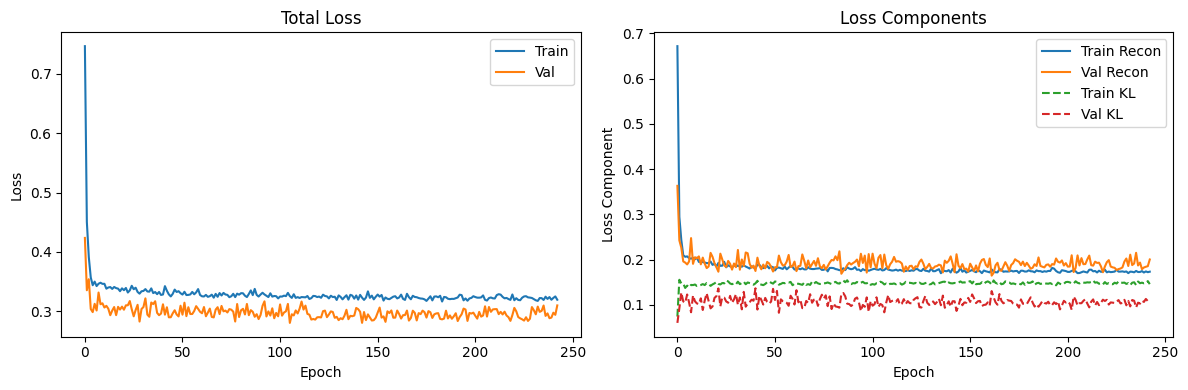

In [6]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# history is a list of TrainStats dataclasses
train_loss = [h.train_loss for h in history]
val_loss = [h.val_loss for h in history]
train_recon = [h.train_recon for h in history]
val_recon = [h.val_recon for h in history]
train_kl = [h.train_kl for h in history]
val_kl = [h.val_kl for h in history]

ax1.plot(train_loss, label='Train')
ax1.plot(val_loss, label='Val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Total Loss')
ax1.legend()

ax2.plot(train_recon, label='Train Recon')
ax2.plot(val_recon, label='Val Recon')
ax2.plot(train_kl, label='Train KL', linestyle='--')
ax2.plot(val_kl, label='Val KL', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss Component')
ax2.set_title('Loss Components')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Load Best Model & Evaluate

In [7]:
# Load best checkpoint
ckpt = torch.load(CHECKPOINT_DIR / "best_model.pt", map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded best model from epoch {ckpt['epoch']}")
print(f"Best val loss: {ckpt['val_loss']:.6f}")

Loaded best model from epoch 143
Best val loss: 0.280676


C:\Users\Admin\AppData\Local\Temp\ipykernel_44068\2715515511.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CHECKPOINT_DIR / "best_model.pt", map_loca

In [8]:
# Standard evaluation on test set
metrics = evaluate_vae(model, bundle.test_loader, DEVICE)

print(f"\n=== Test Set Metrics ===")
print(f"MSE:  {metrics.mse:.6f}")
print(f"MAE:  {metrics.mae:.6f}")
print(f"RMSE: {metrics.rmse:.6f}")


=== Test Set Metrics ===
MSE:  0.162698
MAE:  0.271157
RMSE: 0.403358


## 6. Surface Completion Evaluation (Masking)

Following Bergeron et al., we evaluate the model's ability to complete partially observed surfaces.
We mask 0%, 25%, 50%, and 75% of the surface and measure reconstruction error on the masked points.

In [9]:
# Run masking evaluation
completion_results = evaluate_completion_sweep(
    model=model,
    loader=bundle.test_loader,
    grid_shape=GRID_SHAPE,
    device=DEVICE,
    mask_ratios=(0.0, 0.25, 0.50, 0.75, 0.90, 1),
    seed=42,
    scaler=bundle.scaler,
)

# Print summary table
print_completion_summary(completion_results)

Mask   0.0% | MAE masked: 0.000000 | MAE observed: 0.281523 | MAE full: 0.281523
Mask  25.0% | MAE masked: 0.316749 | MAE observed: 0.313077 | MAE full: 0.313990
Mask  50.0% | MAE masked: 0.367108 | MAE observed: 0.376614 | MAE full: 0.371861
Mask  75.0% | MAE masked: 0.470648 | MAE observed: 0.446401 | MAE full: 0.464554
Mask  90.0% | MAE masked: 0.531194 | MAE observed: 0.537250 | MAE full: 0.531810
Mask 100.0% | MAE masked: 0.570685 | MAE observed: 0.000000 | MAE full: 0.570685

SURFACE COMPLETION EVALUATION
  Mask % |   MSE Masked |   MAE Masked |  RMSE Masked
----------------------------------------------------------------------
    0.0% |     0.000000 |     0.000000 |     0.000000
   24.9% |     0.230597 |     0.316749 |     0.480205
   50.0% |     0.313438 |     0.367108 |     0.559855
   74.9% |     0.469079 |     0.470648 |     0.684894
   89.8% |     0.576497 |     0.531194 |     0.759274
  100.0% |     0.642076 |     0.570685 |     0.801297


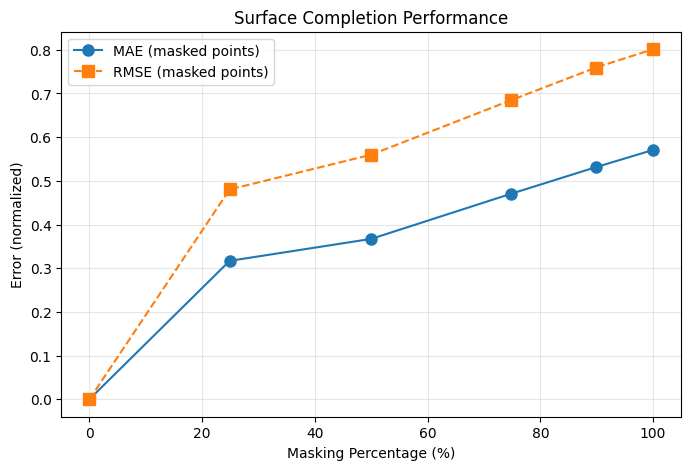

In [10]:
# Plot completion performance
ratios = [r.mask_ratio for r in completion_results]
maes = [r.mae_masked for r in completion_results]
rmses = [r.rmse_masked for r in completion_results]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot([r*100 for r in ratios], maes, 'o-', label='MAE (masked points)', markersize=8)
ax.plot([r*100 for r in ratios], rmses, 's--', label='RMSE (masked points)', markersize=8)
ax.set_xlabel('Masking Percentage (%)')
ax.set_ylabel('Error (normalized)')
ax.set_title('Surface Completion Performance')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 7. Visualize Reconstructions

In [11]:
def plot_surface_comparison(x_orig, x_recon, mask=None, title="Surface Comparison"):
    """Plot original vs reconstructed surface for one channel."""
    fig, axes = plt.subplots(1, 3 if mask is None else 4, figsize=(14, 4))
    
    # Original surface (channel 0 - Calls)
    im0 = axes[0].imshow(x_orig[0], aspect='auto', cmap='viridis')
    axes[0].set_title('Original (Calls)')
    axes[0].set_xlabel('Delta')
    axes[0].set_ylabel('Maturity')
    plt.colorbar(im0, ax=axes[0])
    
    # Reconstructed
    im1 = axes[1].imshow(x_recon[0], aspect='auto', cmap='viridis')
    axes[1].set_title('Reconstructed (Calls)')
    axes[1].set_xlabel('Delta')
    plt.colorbar(im1, ax=axes[1])
    
    # Error
    error = np.abs(x_orig[0] - x_recon[0])
    im2 = axes[2].imshow(error, aspect='auto', cmap='Reds')
    axes[2].set_title('Absolute Error')
    axes[2].set_xlabel('Delta')
    plt.colorbar(im2, ax=axes[2])
    
    if mask is not None:
        im3 = axes[3].imshow(mask[0], aspect='auto', cmap='gray')
        axes[3].set_title('Mask (1=hidden)')
        axes[3].set_xlabel('Delta')
        plt.colorbar(im3, ax=axes[3])
    
    fig.suptitle(title)
    plt.tight_layout()
    return fig

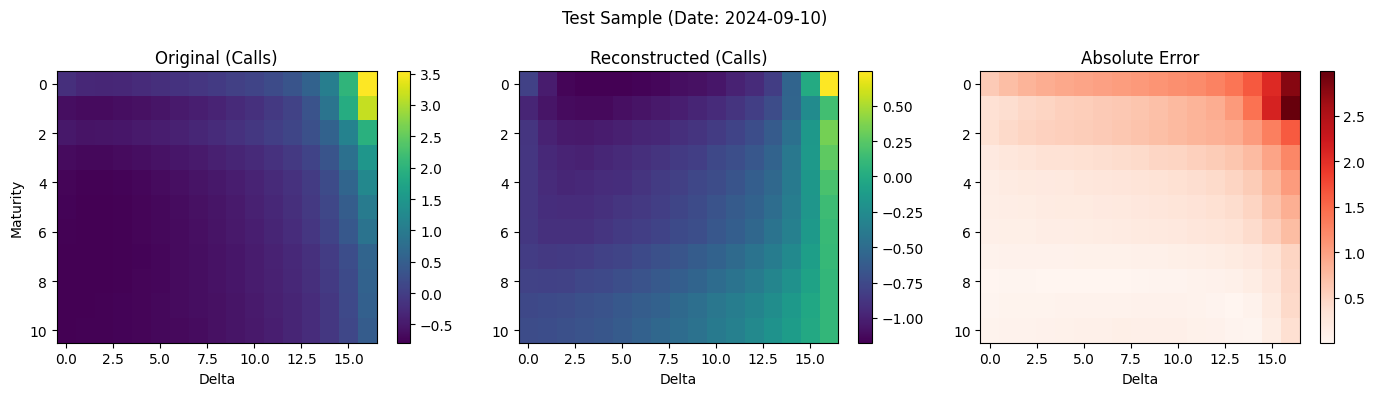

In [12]:
# Get a sample and reconstruct
model.eval()
with torch.no_grad():
    x, date = next(iter(bundle.test_loader))
    x = x.to(DEVICE)
    recon, mu, logvar = model(x)
    
    # Plot first sample
    idx = 0
    x_np = x[idx].cpu().numpy()
    recon_np = recon[idx].cpu().numpy()
    
    plot_surface_comparison(x_np, recon_np, title=f"Test Sample (Date: {date[idx]})")
    plt.show()

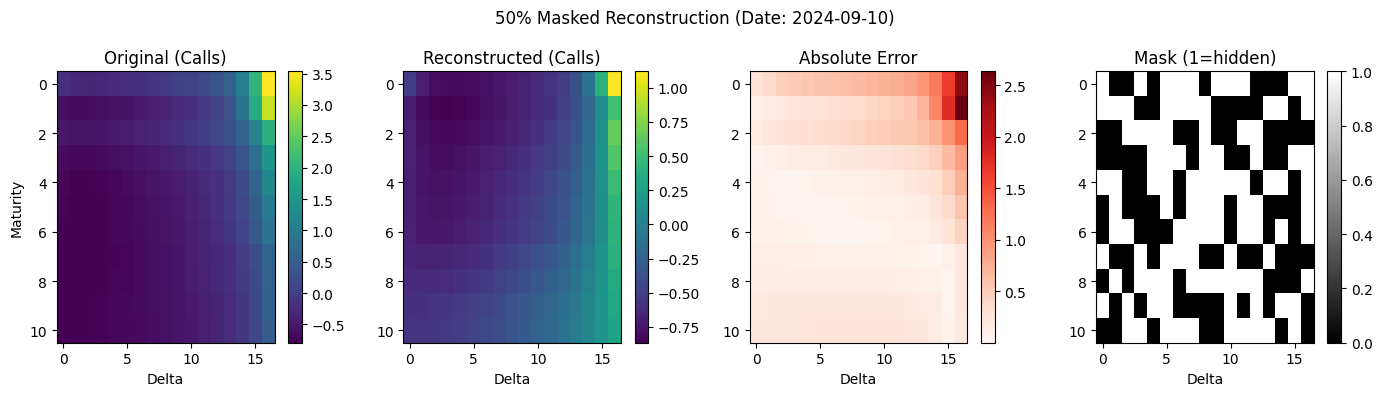

In [13]:
# Visualize masked reconstruction (50% mask)
mask = create_random_mask(GRID_SHAPE, mask_ratio=0.5, seed=42, device=DEVICE)

with torch.no_grad():
    x, date = next(iter(bundle.test_loader))
    x = x.to(DEVICE)
    
    # Apply mask
    x_masked = x * (1 - mask.unsqueeze(0))
    
    # Reconstruct from masked input
    recon, mu, logvar = model(x_masked)
    
    # Plot
    idx = 0
    plot_surface_comparison(
        x[idx].cpu().numpy(),
        recon[idx].cpu().numpy(),
        mask.cpu().numpy(),
        title=f"50% Masked Reconstruction (Date: {date[idx]})"
    )
    plt.show()

## 8. Latent Space Visualization

In [14]:
# Extract latent codes for all test samples
latent_codes = []
dates = []

model.eval()
with torch.no_grad():
    for batch in bundle.test_loader:
        x, d = batch
        x = x.to(DEVICE)
        mu, logvar = model.encode(x)
        latent_codes.append(mu.cpu().numpy())
        dates.extend(d)

latent_codes = np.concatenate(latent_codes, axis=0)
print(f"Latent codes shape: {latent_codes.shape}")

Latent codes shape: (244, 8)


PCA explained variance: 99.9%


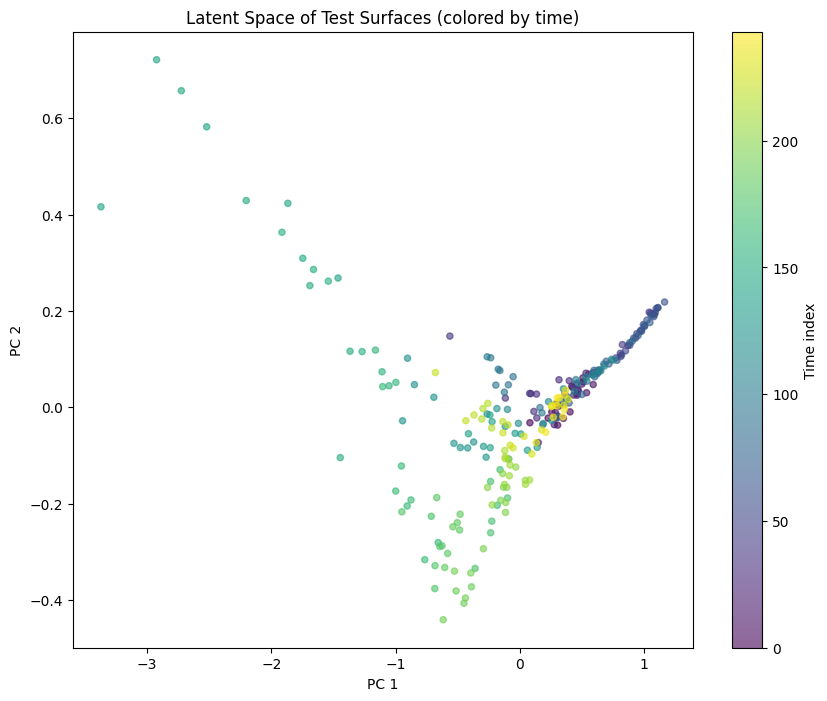

In [15]:
# PCA visualization (if latent_dim > 2)
from sklearn.decomposition import PCA

if LATENT_DIM > 2:
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_codes)
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")
else:
    latent_2d = latent_codes

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                       c=range(len(latent_2d)), cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Time index')
plt.xlabel('Latent Dim 1' if LATENT_DIM <= 2 else 'PC 1')
plt.ylabel('Latent Dim 2' if LATENT_DIM <= 2 else 'PC 2')
plt.title('Latent Space of Test Surfaces (colored by time)')
plt.show()